# Small Language Model

I am building a **small language model** to deepen my understanding of how the **attention mechanism** works, along with the inner workings of the **transformer architecture** and **text generation**.

The goal is to keep the model size around **50-60 million parameters**, but in the end, it ended up being approximately **30 million parameters**.

### Dataset:
The dataset used for this project is the [**TinyStories** dataset](https://huggingface.co/datasets/roneneldan/TinyStories) from Hugging Face.

Through this project, I aim to explore the core principles of transformers and how they handle language generation tasks, while learning about the challenges and intricacies of training and fine-tuning models.

In [1]:
!pip install datasets

In [2]:
pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 20.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [3]:
from datasets import load_dataset
ds = load_dataset('roneneldan/TinyStories')

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00004-2d5a1467fff108(…):   0%|          | 0.00/249M [00:00<?, ?B/s]

data/train-00001-of-00004-5852b56a2bd28f(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/train-00002-of-00004-a26307300439e9(…):   0%|          | 0.00/246M [00:00<?, ?B/s]

data/train-00003-of-00004-d243063613e5a0(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/validation-00000-of-00001-869c898b5(…):   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

In [4]:
!pip install tiktoken
import tiktoken
import os
import numpy as np
from tqdm.auto import tqdm

enc = tiktoken.get_encoding("gpt2")

def process(example):
  ids = enc.encode_ordinary(example["text"])
  out = {'ids':ids,'len':len(ids)}
  return out

if not os.path.exists("train.bin"):
  tokenized = ds.map(
      process,
      remove_columns=['text'],
      desc = 'tokenizing the splits',
      num_proc= 8,
  )
  for split,dset in tokenized.items():
    arr_len = np.sum(dset['len'],dtype=np.uint64)
    filename = f'{split}.bin'
    dtype = np.uint16
    arr = np.memmap(filename,dtype=dtype,mode='w+',shape=(arr_len,))
    total_batches = 1024

    idx = 0
    for batch_idx in tqdm(range(total_batches), desc=f"writing ({filename})"):
      batch = (dset.shard(num_shards=total_batches, index=batch_idx, contiguous=True).with_format("numpy"))
      arr_batch = np.concatenate(batch["ids"])
      arr[idx: idx + len(arr_batch)] = arr_batch
      idx += len(arr_batch)
    arr.flush()

tokenizing the splits (num_proc=8):   0%|          | 0/2119719 [00:00<?, ? examples/s]

tokenizing the splits (num_proc=8):   0%|          | 0/21990 [00:00<?, ? examples/s]

writing (train.bin):   0%|          | 0/1024 [00:00<?, ?it/s]

writing (validation.bin):   0%|          | 0/1024 [00:00<?, ?it/s]

In [5]:
import torch

In [6]:
def get_batch(split):
    if split == "train":
        data = np.memmap("train.bin", dtype=np.uint16, mode="r")
    else:
        data = np.memmap("validation.bin", dtype=np.uint16, mode="r")
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([
        torch.from_numpy(data[i:i + block_size].astype(np.int64))
        for i in ix
    ])
    y = torch.stack([
        torch.from_numpy(data[i + 1:i + 1 + block_size].astype(np.int64))
        for i in ix
    ])
    if device_type == "cuda":
        # Pin arrays x, y to allow async GPU transfer
        x = x.pin_memory().to(device, non_blocking=True)
        y = y.pin_memory().to(device, non_blocking=True)
    else:
        x = x.to(device)
        y = y.to(device)
    return x, y

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
import numpy as np
from tqdm.auto import tqdm
from contextlib import nullcontext
import os

In [8]:
class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None
    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

In [9]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.flash = hasattr(F, 'scaled_dot_product_attention')
        if not self.flash:
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                       .view(1, 1, config.block_size, config.block_size))
    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)


        if self.flash:
            y = F.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.attn_dropout.p if self.training else 0.0, is_causal=True)
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v

        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

In [10]:
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
    def forward(self, x):
        return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))

In [11]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNorm(config.n_embd, config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln2 = LayerNorm(config.n_embd, config.bias)
        self.mlp = MLP(config)
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

In [12]:
@dataclass
class GPTConfig:
    block_size: int
    vocab_size: int
    n_layer: int
    n_head: int
    n_embd: int
    dropout: float = 0.0
    bias: bool = True

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte=nn.Embedding(config.vocab_size, config.n_embd),
            wpe=nn.Embedding(config.block_size, config.n_embd),
            drop=nn.Dropout(config.dropout),
            h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f=LayerNorm(config.n_embd, config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight  # weight tying

        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size
        pos = torch.arange(0, t, dtype=torch.long, device=device)

        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
            return logits, loss
        else:
            logits = self.lm_head(x[:, [-1], :])
            return logits, None

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Generate tokens given a conditioning sequence.
        idx: Tensor of shape (B, T)
        """
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

In [13]:
config = GPTConfig(
    vocab_size=50257,
    block_size=128,
    n_layer=6,
    n_head=6,
    n_embd=384,
    dropout=0.1,
    bias=True
)

model = GPT(config)

In [14]:
def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(split)
                with ctx:
                    logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

In [15]:
# Training Config
import torch
from contextlib import nullcontext

learning_rate = 1e-4
max_iters = 10000
warmup_steps = 1000
min_lr = 5e-4
eval_iters = 500
batch_size = 32
block_size = 128

gradient_accumulation_steps = 32

device =  "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu'
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(42)

In [16]:
from torch.optim.lr_scheduler import LinearLR,SequentialLR, CosineAnnealingLR
optimizer =  torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=0.1, eps=1e-9)

scheduler_warmup = LinearLR(optimizer, total_iters = warmup_steps)
scheduler_decay = CosineAnnealingLR(optimizer,T_max = max_iters - warmup_steps, eta_min = min_lr)
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps])
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

/tmp/ipython-input-1635467186.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


In [17]:
best_val_loss = float('inf')
best_model_params_path = "best_model_params.pt"
train_loss_list, validation_loss_list = [], []
model = model.to(device)
for epoch in tqdm(range(max_iters)):
    if epoch % eval_iters == 0 and epoch != 0:
        losses = estimate_loss(model)
        print(f"Epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(f"The current learning rate: {optimizer.param_groups[0]['lr']:.5f}")
        train_loss_list += [losses['train']]
        validation_loss_list += [losses['val']]

        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            torch.save(model.state_dict(), best_model_params_path)
    X, y = get_batch("train")
    X, y = X.to(device), y.to(device)
    with ctx:
        logits, loss = model(X, y)
        loss = loss / gradient_accumulation_steps
        scaler.scale(loss).backward()

    if ((epoch + 1) % gradient_accumulation_steps == 0) or (epoch + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    scheduler.step()

  0%|          | 0/10000 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:1195: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  scheduler.step()


Epoch 500: train loss 9.4424, val loss 9.4479
The current learning rate: 0.00007
Epoch 1000: train loss 8.4666, val loss 8.4711
The current learning rate: 0.00010
Epoch 1500: train loss 7.5244, val loss 7.5210
The current learning rate: 0.00010
Epoch 2000: train loss 6.6461, val loss 6.6411
The current learning rate: 0.00011
Epoch 2500: train loss 5.8788, val loss 5.8729
The current learning rate: 0.00013
Epoch 3000: train loss 5.3098, val loss 5.3051
The current learning rate: 0.00015
Epoch 3500: train loss 4.8297, val loss 4.8288
The current learning rate: 0.00017
Epoch 4000: train loss 4.4719, val loss 4.4719
The current learning rate: 0.00020
Epoch 4500: train loss 4.2086, val loss 4.2141
The current learning rate: 0.00023
Epoch 5000: train loss 3.9900, val loss 3.9966
The current learning rate: 0.00027
Epoch 5500: train loss 3.8123, val loss 3.8126
The current learning rate: 0.00030
Epoch 6000: train loss 3.6577, val loss 3.6558
The current learning rate: 0.00033
Epoch 6500: train

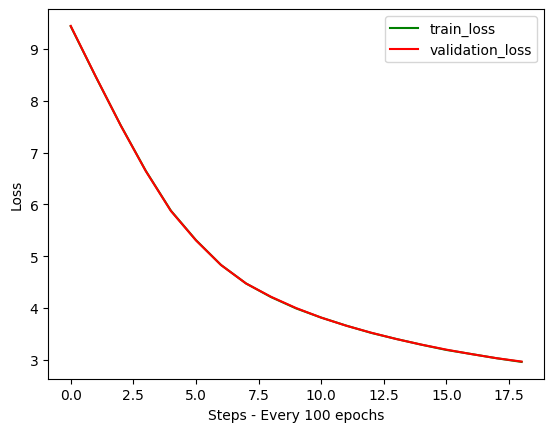

In [18]:
import matplotlib.pyplot as plt
train_loss_list_converted = [i.cpu().detach() for i in train_loss_list]
validation_loss_list_converted = [i.cpu().detach() for i in validation_loss_list]

plt.plot(train_loss_list_converted, 'g', label='train_loss')
plt.plot(validation_loss_list_converted, 'r', label='validation_loss')
plt.xlabel("Steps - Every 100 epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Inference

In [21]:
torch.save(model.state_dict(), 'model.pth')  # saving model

In [24]:
model = GPT(config)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
best_model_params_path = "best_model_params.pt"
model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device)))
model.eval()

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 384)
    (wpe): Embedding(128, 384)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_features=1152, bias=True)
          (c_proj): Linear(in_features=384, out_features=384, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=384, out_features=1536, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=1536, out_features=384, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=384, out_features=50257, bias=False)
)

In [26]:
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
sentence = "Once upon a time there was a girl."
context = tokenizer.encode(sentence, return_tensors='pt').to(device)
y = model.generate(context, max_new_tokens=200)
generated_text = tokenizer.decode(y.squeeze().tolist(), skip_special_tokens=True)
print(generated_text)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Once upon a time there was a girl. She loved to have sand and swimming. One day, she went along the lake and noticed a small rabbit came running. He was looking very high and it started to cry. He said: "That course I don't think I will try it and far moved away." He quickly down the What dayJerry'sThatâ€™t worry, littleie would get it. He just counted to peak and fell off his wound. He was so proud of himself until he felt better and allowed the owl.

The neighbour's mom swung back and defeat the leader pedams and smiled back.

iamond Emily's little reminded himself what spaghetti stage and the wise 3 year. He hugged the rubber dinosaur and it turn home. He fell onto the squirrel and showed the paths, it was in it and watching him new boot.

The player started to cry, but it was too busy. He quickly helped him granted the superhero, tiara. Alex was so happy that he sang out


In [28]:
# Example 1: New sentence
sentence_1 = "The sun was setting over the hills."
context_1 = tokenizer.encode(sentence_1, return_tensors='pt').to(device)
y_1 = model.generate(context_1, max_new_tokens=200)
generated_text_1 = tokenizer.decode(y_1.squeeze().tolist(), skip_special_tokens=True)
print("Generated Text 1:", generated_text_1)

Generated Text 1: The sun was setting over the hills. The shark ate a big bucket. It was so beautiful when the television were having both raising such a bit of loyal family.

From that day drove off, the bird finished the bird and the bear carrying lots of fun and grateful for the bird.Once upon a time, there was a young boy named Bob. One day, found a big whale. He had a difficult blue worked in the tree and passed mushrooms on the forest. He was so excited and brave. He ran as he laughed until he went on the forest.

Seeing he played with his teacher and dad plack and rolled the white legs. He shook his mouth and felt Zoomy. He flew away again and laughed and thanked the rabbit.

He waved to his friends and in his home. He threw the sunrise with the bell and looked for him. He thanked his nice squirrel. He began to hop around and reached out of the stream and found his window chubby jet Have fun!One day, a


## Final Note

This model is not perfect, but I am extremely proud of what I've achieved. Building this model from scratch has been an incredible learning experience. More importantly, I gained a deeper understanding of how **transformers** work, including the core mechanisms like **self-attention**, **multi-head attention**, **positional encoding**, and **contextualization** of tokens.

While the model's performance could certainly improve with more training or optimizations, the process of developing it has taught me a great deal about **deep learning**, **natural language processing (NLP)**, and the practical challenges of working with large-scale models.

I'm excited to continue exploring and improving upon this work in future projects. Thank you for taking the time to go through this!